# Regression results

In [17]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polyfeat_imp import *
from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [4]:
y_classes = get_yclasses(params, ker_integrals)
y_classes.head()

,αx,αz,len_scale
0,0.000140,0.004113,3.471444
1,0.000288,0.005442,2.838588
2,0.000948,0.000869,4.783256
3,0.008380,0.014527,1.950423
4,0.000710,0.013350,1.764475


# Regression

## Pointwise features

In [5]:
import sklearn 
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [11]:
rscl_df = pd.DataFrame(rscl_data, 
                       columns=[F'feat{i+1}' for i in range(len(rscl_data[0]+1))])
rscl_df.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,feat39,feat40,...,feat261,feat262,feat263,feat264,feat265,feat266,feat267,feat268,feat269,feat270,feat271,feat272,feat273,feat274,feat275,feat276,feat277,feat278,feat279,feat280,feat281,feat282,feat283,feat284,feat285,feat286,feat287,feat288,feat289,feat290,feat291,feat292,feat293,feat294,feat295,feat296,feat297,feat298,feat299,feat300
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0.012752,0.011716,0.010124,0.008314,0.006670,0.005512,0.004990,0.005112,0.005866

In [12]:
X_train_ts , X_test_ts, y_train_ts, y_test_ts = train_test_split(rscl_df, y_classes['αx'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [13]:
basemodel_ax = RandomForestRegressor(oob_score=True, n_jobs=-1)
basemodel_ax.fit(X_train_ts, y_train_ts)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [14]:
basemodel_ax.score(X_test_ts, y_test_ts)

0.965985046962786

In [15]:
print('OOB Score: ', basemodel_ax.oob_score_)

OOB Score:  0.9620732450083112


     feature        fi
116  feat117  0.129311
69    feat70  0.070677
44    feat45  0.053250
127  feat128  0.044265
126  feat127  0.041237
68    feat69  0.031786
43    feat44  0.031029
230  feat231  0.028336
45    feat46  0.017056
21    feat22  0.016536


<Figure size 1008x576 with 0 Axes>

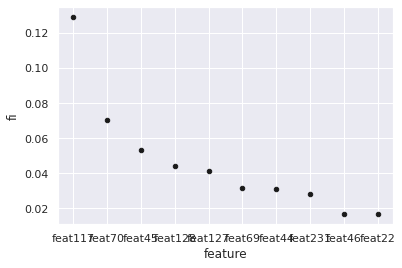

In [20]:
plt.figure(figsize=(14,8))
fi_ts = get_fi(basemodel_ax, rscl_df,'timeseries',)
fi_ts[:10].plot.scatter('feature', 'fi', color='k')
print(fi_ts[:10])

In [23]:
ts_ax_fi_data = features_vs_r2(rscl_df, 'timeseries', y=y_classes['αx'], 
               model=basemodel_ax, test_size=0.2, cv=3, niters=10, stratify=params['stencil_type'])

Running iter 1
Number of features: 300
Size of training and test set: ((8400, 300), (2100, 300))
Computing cross-validation scores
Cross val-scores: 0.952 +- 0.00121
Done! 
 Fitting model
Model Out-of-Bag score: 0.962
Test score: 0.966

Running iter 2
Number of features: 150
Size of training and test set: ((8400, 150), (2100, 150))
Computing cross-validation scores
Cross val-scores: 0.952 +- 0.00115
Done! 
 Fitting model
Model Out-of-Bag score: 0.963
Test score: 0.967

Running iter 3
Number of features: 75
Size of training and test set: ((8400, 75), (2100, 75))
Computing cross-validation scores
Cross val-scores: 0.95 +- 0.00154
Done! 
 Fitting model
Model Out-of-Bag score: 0.96
Test score: 0.965

Running iter 4
Number of features: 38
Size of training and test set: ((8400, 38), (2100, 38))
Computing cross-validation scores
Cross val-scores: 0.941 +- 0.00094
Done! 
 Fitting model
Model Out-of-Bag score: 0.954
Test score: 0.954

Running iter 5
Number of features: 19
Size of training and t

In [26]:
niters_ts_ax = 10
nfeats_ts_ax = [ts_ax_fi_data[i][0] for i in range(niters_ts_ax)]
cv_scores_ts_mean_ax = [ts_ax_fi_data[i][4][0] for i in range(niters_ts_ax)]
cv_scores_ts_std_ax = [ts_ax_fi_data[i][4][1] for i in range(niters_ts_ax)]
oob_scores_ts_ax = [ts_ax_fi_data[i][5] for i in range(niters_ts_ax)]
test_scores_ts_ax = [ts_ax_fi_data[i][6] for i in range(niters_ts_ax)]

ts_reg_results = [nfeats_ts_ax, cv_scores_ts_mean_ax, cv_scores_ts_std_ax, 
                  oob_scores_ts_ax, test_scores_ts_ax ]

In [27]:
fi_ts = pd.DataFrame(np.array(ts_reg_results).T,
             columns=['n_feats', 'cv_mean', 'cv_std', 'oob_score', 'test_score'])

fi_ts.head()

,n_feats,cv_mean,cv_std,oob_score,test_score
0,300.0,0.951853,0.001207,0.962376,0.965710
1,150.0,0.952118,0.001153,0.962921,0.967360
2,75.0,0.950499,0.001543,0.959852,0.964712
3,38.0,0.941287,0.000940,0.953623,0.954087
4,19.0,0.935544,0.001189,0.945888,0.948188


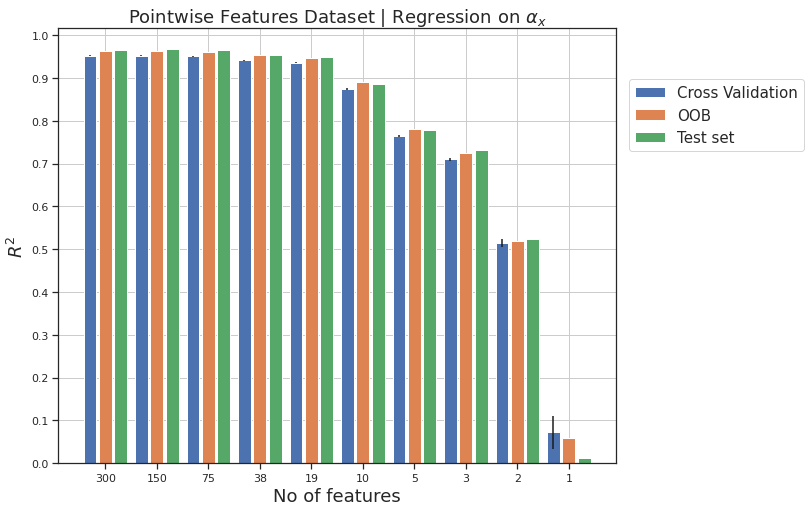

In [35]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(10,8))

X = [str(i) for i in nfeats_ts_ax]
ax.bar(x=np.arange(len(X))-0.3, height=cv_scores_ts_mean_ax,
       yerr=cv_scores_ts_std_ax, width=0.25, label='Cross Validation' )
ax.bar(x=np.arange(len(X)), height=oob_scores_ts_ax, width=0.25, label='OOB' )
ax.bar(x=np.arange(len(X))+0.3, height=test_scores_ts_ax, width=0.25, label='Test set' )

plt.xticks(np.arange(len(X)), X)
plt.xlabel("No of features", fontsize=18)
plt.ylabel("$R^2$", fontsize=18)
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Pointwise Features Dataset"+r" | Regression on $\alpha _x$", fontsize=18)

plt.legend(bbox_to_anchor=[1.01,0.9], prop={'size':15})
plt.grid()
plt.show()

In [38]:
ts_ax_fi_data[5][1]

0     feat117
3      feat45
4     feat128
1     feat127
2      feat70
6     feat231
10    feat213
7      feat22
11     feat69
5      feat44
Name: feature, dtype: object

# $\alpha_y$ regression